# Testing plots for method comparison

In [2]:
import sys
sys.path.append('/home/jjwhit/rcGAN/')
import torch
import yaml
import types
import json

import numpy as np
import matplotlib.patches as patches

from data.lightning.MassMappingDataModule import MMDataModule
from data.lightning.MassMappingDataModule import MMDataTransform 
from models.lightning.mmGAN import mmGAN
from utils.mri.math import tensor_to_complex_np
from utils.mri import transforms
from mass_map_utils.scripts.ks_utils import Gaussian_smoothing, ks93, ks93
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import find_contours

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def load_object(dct):
    return types.SimpleNamespace(**dct)

In [5]:
torch.set_float32_matmul_precision('medium')

with open('/home/jjwhit/rcGAN/configs/mass_map.yml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg = json.loads(json.dumps(cfg), object_hook=load_object)

dm = MMDataModule(cfg)
fig_count = 1
dm.setup()
test_loader = dm.test_dataloader()

with torch.no_grad():
    mmGAN_model = mmGAN.load_from_checkpoint(
        checkpoint_path='/share/gpu0/jjwhit/mass_map/mm_models/mmgan_training_cosmos/checkpoint_best.ckpt')

    mmGAN_model.cuda()

    mmGAN_model.eval()

In [7]:
for i, data in enumerate(test_loader):
    y, x, mean, std = data
    y = y.cuda()
    x = x.cuda()
    mean = mean.cuda()
    std = std.cuda()

    gens_mmGAN = torch.zeros(size=(y.size(0), cfg.num_z_test, cfg.im_size, cfg.im_size, 2)).cuda()

    for z in range(cfg.num_z_test):
        gens_mmGAN[:, z, :, :, :] = mmGAN_model.reformat(mmGAN_model.forward(y))

    avg_mmGAN = torch.mean(gens_mmGAN, dim=1)

    gt = mmGAN_model.reformat(x)
    zfr = mmGAN_model.reformat(y)

    for j in range(y.size(0)):
        np_avgs = {
            'mmGAN': None,
        }

        np_samps = {
            'mmGAN': [],
        }

        np_stds = {
            'mmGAN': None,
        }

        np_gt = None

        np_gt = ndimage.rotate(
            torch.tensor(tensor_to_complex_np((gt[j] * std[j] + mean[j]).cpu())).abs().numpy(), 180)
        np_zfr = ndimage.rotate(
            torch.tensor(tensor_to_complex_np((zfr[j] * std[j] + mean[j]).cpu())).abs().numpy(), 180)

        np_avgs['mmGAN'] = ndimage.rotate(
            torch.tensor(tensor_to_complex_np((avg_mmGAN[j] * std[j] + mean[j]).cpu())).abs().numpy(),
            180)

        for z in range(cfg.num_z_test):
            np_samps['mmGAN'].append(ndimage.rotate(torch.tensor(
                tensor_to_complex_np((gens_mmGAN[j, z] * std[j] + mean[j]).cpu())).abs().numpy(), 180))

        np_stds['mmGAN'] = np.std(np.stack(np_samps['mmGAN']), axis=0)

        method = 'mmGAN'
        zoom_length = 80  # Adjust this value based on your preference
        margin = 10  # Adjust this value to set the margin

        # Ensure the square is not touching the edge
        zoom_startx = np.random.randint(margin, cfg.im_size - zoom_length - margin)
        zoom_starty1 = np.random.randint(margin, int(cfg.im_size / 2) - zoom_length - margin)
        zoom_starty2 = np.random.randint(int(cfg.im_size / 2) + margin, cfg.im_size - zoom_length - margin)

        p = np.random.rand()
        zoom_starty = zoom_starty1 if p <= 0.5 else zoom_starty2

        x_coord = zoom_startx + zoom_length
        y_coords = [zoom_starty, zoom_starty + zoom_length]


        mask =  np.load(
            cfg.cosmo_dir_path + 'cosmos_mask.npy', allow_pickle=True
        ).astype(bool)

OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 39.39 GiB total capacity; 36.71 GiB already allocated; 24.44 MiB free; 37.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:
from astropy.io import fits

In [16]:
cosmos_dlp = fits.getdata('/share/gpu0/jjwhit/remy2022_results/cosmos/dlp_cosmos_mean_hdu.fits')

In [17]:
# Calculate the starting indices for the center 300x300 portion
start_row = (cosmos_dlp.shape[0] - 300) // 2
start_col = (cosmos_dlp.shape[1] - 300) // 2

# Extract the center 300x300 portion
center_portion = cosmos_dlp[start_row:start_row + 300, start_col:start_col + 300]

In [22]:
center_portion.shape

(300, 300)

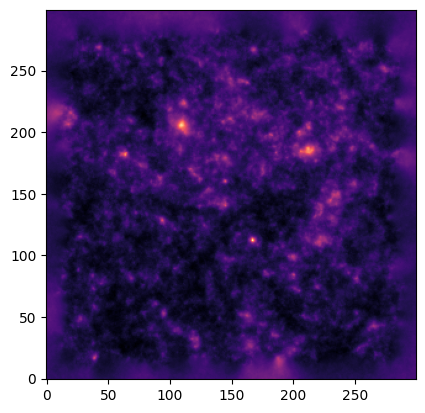

In [23]:
plt.imshow(center_portion, cmap='magma', origin='lower')